# Wavelet Analysis - Visualization

### Author: Karen Ficenec

This notebook creates a wavelet analysis visualization that was used in a conference paper. It examines the data at the month level because this timescale produces the most illustrative graph.

Wavelet analysis is similar to a windowed fourier transform, but does better because the size of the window changes. The mathematics behind wavelet analysis allows it to detect many different frequencies and how those frequencies change over time (it looks at data in the frequency *and* the time domain). 

In this case, the data didn't show any major trends (for example frequencies did not change from very low to very high across time), but there were still some interesting fluctuations and identifying where the prominant frequencies were also proved useful for our analysis.

### Sources

code adapted from:
http://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/

Articles about wavelets:
- Graps, A., An Introduction to Wavelets.IEEE Computational Science and Engineering, 1995.

- Cazelles, B., M. Chaves, and D. Berteaux, Wavelet Analysis of Ecological Time Series. Population Ecology, 2008.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from dateutil.relativedelta import *
import pywt
import pycwt
from pandas.plotting import register_matplotlib_converters
import athena
register_matplotlib_converters()

In [3]:
# Pull summary table
db = athena.database.AthenaDatabase(cache=True, write=True)
df = db.summary_table()
signal_name = 'vehicles'

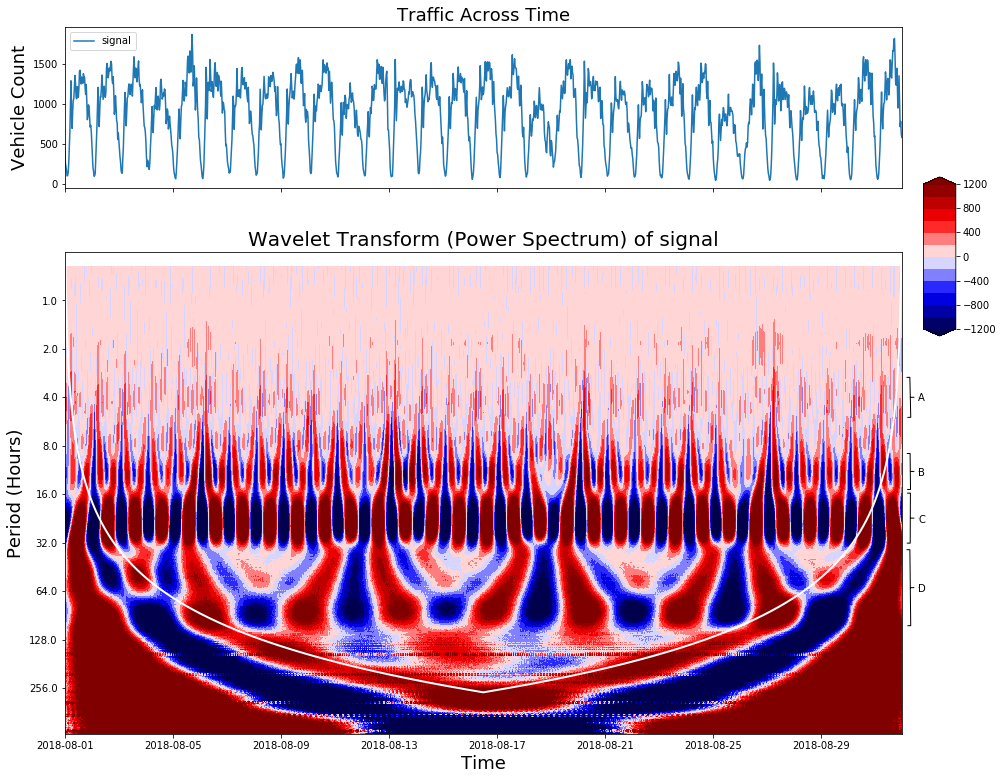

In [5]:
def plot_wavelet(time, signal, scales, start_datetime,
                 wavelet_name_for_pywt = 'morl', 
                 wavelet_name_for_pycwt = 'morlet', 
                 cmap = plt.cm.seismic, 
                 title = 'Wavelet Transform (Power Spectrum) of signal', 
                 ylabel = 'Period (Hours)', 
                 xlabel = 'Time', 
                 contour_levels = [-30,-20,-10,0,10,20,30], 
                 annote = False):
    
    """ This function plots the original timeseries signal and it's wavelet transform. 
    
    Args:
    time: an np series of time expressed as floats in hour units
        If your data is not in hour units, the axis titles and x axis label will be incorrect.
        e.g. for half hour data series: [0, 0.5, 1, 1.5, ... ]
    signal: an np series of the values of the signal you would like to analyze, must match length of time series.
    scales: The frequencies that you would like analyzed
        units will be in terms of the given time series...
        so for the above example, 1 would look for 1-hour period within your dataset.
    start_datetime: This is for graphing purposes only. It displays the x label in
        terms of actual datetimes. 
    wavelet_name_for_pywt: The name of the analyzing wavelet (a.k.a. mother wavelet) for the wavelet
        tranform to be used by the pywt package for the actual plotting of the wavelet transform.
        Look to pywt.cwt for documentation on names.
    wavelet_name_for_pycwt: The name of the analyzing wavelet for the wavelet tranform to be used by
        the pycwt package for plotting the cone of influence. These two types should match in meaning, 
        but the spelling is different between the two packages (e.g. 'morl' vs. 'morlet'). 
        Look to pycwt.cwt for documentation on names.
    cmap: defines the color map for the graph.
    title: A string of the desired title for the wavelet transform graph.
    ylabel: A string of the desired y axis title for the graph.
    xlabel: A string of the desired x axis title for the graph.
    contour_levels: Controls the colors of the graph, if not scaled appropriately, the graph may
        be all the same color and appear to show no results. Tinkering with the scale of the
        contour coloring can help alleviate this.
    annote: Set to True if you want the annotations that fit specifically to the data presented in 
        the paper on this material.
    
    Returns: the plot of the signal and wavelet analysis (on two matplotlib axis)
    
    """
    
    dt = time[1] - time[0]
    #pywt is used to plot the actual wavelet transform.
    [coefficients, frequencies] = pywt.cwt(signal, scales, wavelet_name_for_pywt, dt)
    #pycwt is used to obtain & display the cone of influence (coi), the other outputs are not used.
    coefs, scales2, freqs, coi, fft, fftfreqs = pycwt.cwt(signal, dt, wavelet=wavelet_name_for_pycwt, freqs=scales)
    power = (abs(coefficients)) ** 2  #conversions for the log scale of the graph.
    period = 1. / frequencies
    
    start_datetime = pd.to_datetime(start_datetime)
    time_x_label = [start_datetime.normalize() + timedelta(hours=x) for x in time]
    time_df = pd.DataFrame({'datetime': time_x_label}, dtype = 'datetime64[ns]').set_index('datetime')
    
    fig, (ax1, ax2) = plt.subplots(2,1, sharex = True, figsize=(15, 13), gridspec_kw={'height_ratios': [1, 3]})
    ax1.plot(time_x_label, signal, label='signal')
    ax1.set_xlim([time_x_label[0], time_x_label[-1]])
    ax1.set_ylabel('Vehicle Count', fontsize=18)
    ax1.set_title('Traffic Across Time', fontsize=18)
    ax1.legend()
    
    im = ax2.contourf(time_x_label, np.log2(period), coefficients, contour_levels, extend='both',cmap=cmap)
    ax2.plot(time_x_label, np.log2(coi), color = 'white', linewidth= 2.)
    
    ax2.set_title(title, fontsize=20)
    ax2.set_ylabel(ylabel, fontsize=18)
    ax2.set_xlabel(xlabel, fontsize=18)
    
    yticks = 2**np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max())))
    ax2.set_yticks(np.log2(yticks))
    ax2.set_yticklabels(yticks)
    ax2.invert_yaxis()
    ylim = ax2.get_ylim()
    ax2.set_ylim(ylim[0], -1)
    if annote == True:
        plt.annotate("C", xy=(0.915, 0.33), xycoords='figure fraction',
                     xytext=(0.915,  0.33), textcoords='figure fraction')
        plt.annotate('C', xy=(0.905, 0.3357), xytext=(0.915, 0.335), xycoords='figure fraction', 
                fontsize=0.1,ha='center', va='bottom',
                arrowprops=dict(arrowstyle='-[, widthB=25., lengthB=3., angleB=-20.', lw=1.0))
        plt.annotate("D", xy=(0.915, 0.241), xycoords='figure fraction',
                 xytext=(0.915,  0.241), textcoords='figure fraction')
        plt.annotate('D', xy=(0.905, 0.2465), xytext=(0.915, 0.246), xycoords='figure fraction', 
            fontsize=0.1,ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=38., lengthB=3.', lw=1.0))
        plt.annotate("B", xy=(0.915, 0.39), xycoords='figure fraction',
             xytext=(0.915,  0.39), textcoords='figure fraction')
        plt.annotate('B', xy=(0.905, 0.3955), xytext=(0.915, 0.395), xycoords='figure fraction', 
            fontsize=0.1,ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=18., lengthB=3.', lw=1.0))
        plt.annotate("A", xy=(0.915, 0.486), xycoords='figure fraction',
            xytext=(0.915,  0.486), textcoords='figure fraction')
        plt.annotate('A', xy=(0.905, 0.4905), xytext=(0.915, 0.49), xycoords='figure fraction', 
            fontsize=0.1,ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=20., lengthB=3.', lw=1.0))
    
    #The list below contains [legend-start-on-x-axis, legend-start-on-y-axis,
    # legend-length-along-x-axis, legend-length-along-y-axis] in units of fraction of the axis.
    cbar_ax = fig.add_axes([0.92, 0.55, 0.03, 0.17])
    fig.colorbar(im, cax=cbar_ax, orientation="vertical") #add the color legend to the figure

    return plt

start_date = '2018-08-01'

#transform the signal into a one-dimensional np series
data = df[signal_name]['2018-08']
signal = data.values.squeeze()

t0=0
dt=0.5
N = data.shape[0]
time = np.arange(0, N) * dt + t0  #creates the numpy time series
 
scales = np.arange(1, 800) #the frequencies to analyze in the signal over time
#contour_levels to create a nice looking graph were found through experimentation (trying different values)
contour_levels_for_good_colors = [-1200, -1000, -800, -600, -400, -200, 0, 200, 400, 600, 800, 1000, 1200]

#call the wavelet plotting function
plot_wavelet(time, signal, scales, start_datetime = start_date,
             contour_levels = contour_levels_for_good_colors, annote = True)

#(optionally save) and display the wavelet analysis graph
#fp = 'yourFilePathHere/'
#plt.savefig(fp + "WaveletTrafficAugustNegativesShown.png", bbox_inches='tight')
plt.show()

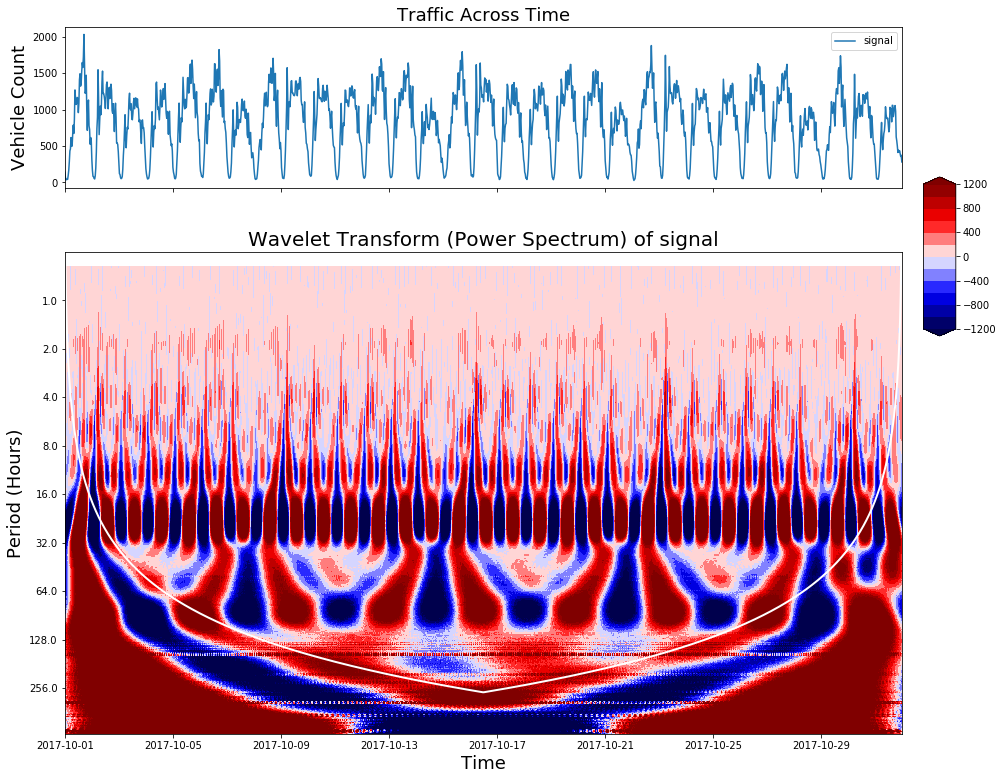

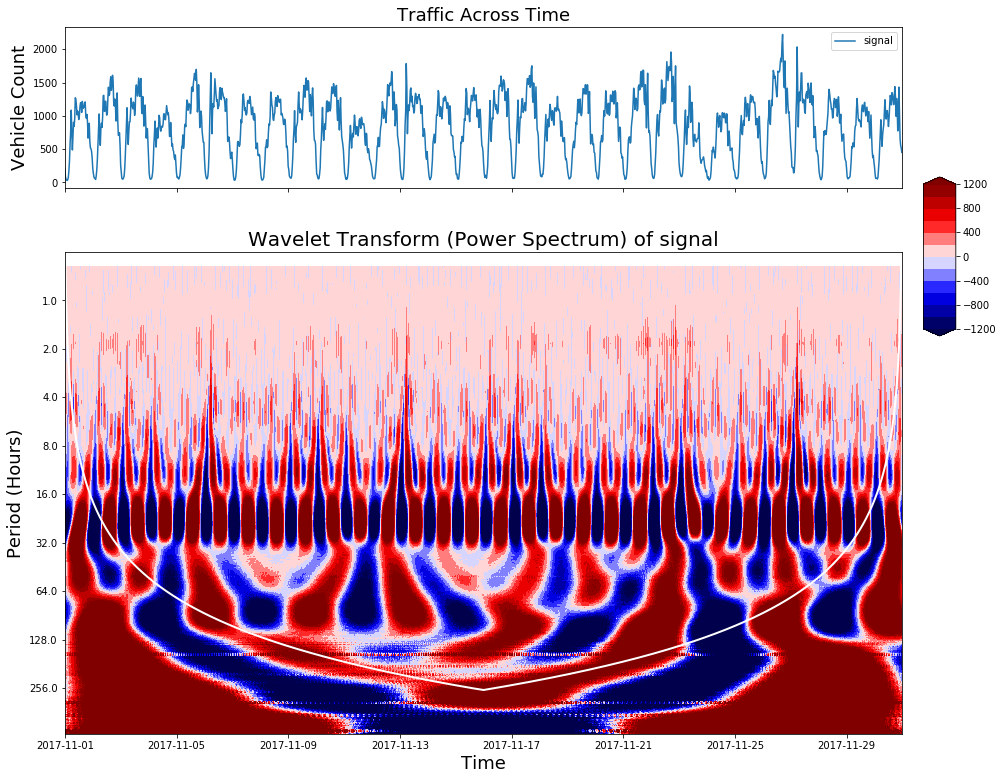

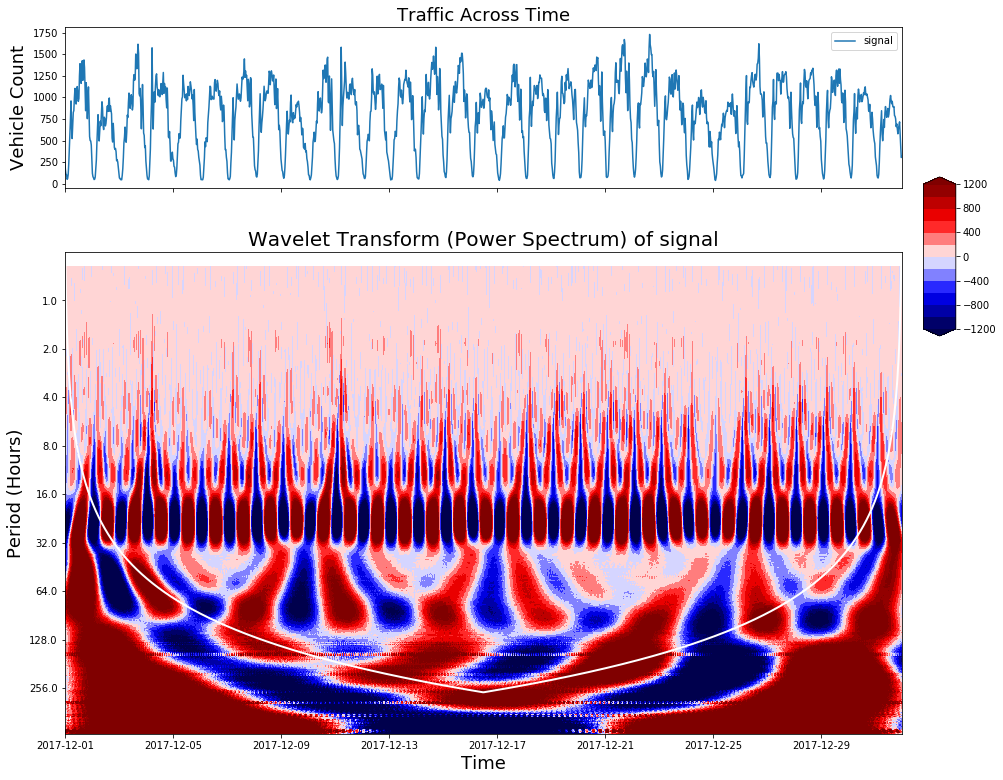

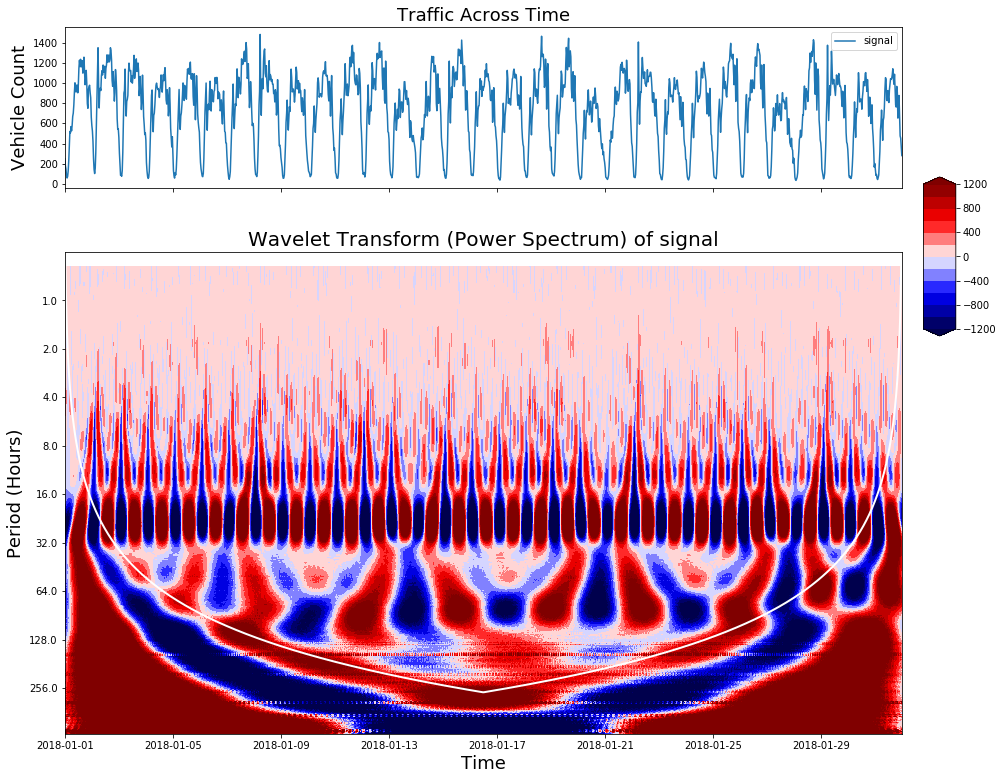

In [ ]:
# By looping over months, this cell plots the wavelet analysis for each month for a year.
for i in range(12):
    start_date = '2017-10-01'
    start_date = pd.to_datetime(start_date)
    start_date = start_date + relativedelta(months=i)
    month_year_string = str(start_date.year) + "-" + str(start_date.month)
    start_date = month_year_string + "-" + "01"
    data = df[signal_name][month_year_string]
    N = data.shape[0]
    signal = data.values.squeeze()

    t0=0
    dt=0.5
    time = np.arange(0, N) * dt + t0

    scales = np.arange(1, 800)
    plot_wavelet(time, signal, scales, start_datetime = start_date,
                 contour_levels = contour_levels_for_good_colors)
    #fp = 'yourFilePathHere/'
    #plt.savefig(fp + month_year_string.replace("-", "_") + "_waveletPicsTraffic.png")
    plt.show()
    